In [139]:
import pandas as pd
from io import StringIO
import seaborn as sns 
import matplotlib.pyplot as plt
import itertools


In [2]:
import os
import re

# Assuming 'path_to_results' is the path to the 'tcp-bbr-cubic-results' directory
path_to_results = "../../tcp-bbr-cubic-results"
results = []

# List all directories within the results directory
directories = [d for d in os.listdir(path_to_results) if os.path.isdir(os.path.join(path_to_results, d))]

# Parse each directory name to extract the fields
for directory in directories:
    parts = directory.split('_')
    if len(parts) == 4:  # Ensure the directory name contains all expected parts
        packet_size = parts[0]  # e.g., 100kB
        bandwidth = parts[1]    # e.g., 250Mbps
        latency = parts[2]      # e.g., 50.0ms
        tcp_algorithm = parts[3]  # e.g., TcpBbr

        print(f"Packet size: {packet_size}, Bandwidth: {bandwidth}, Latency: {latency}, TCP algorithm: {tcp_algorithm}")
        
        goodput_retransmission_path = os.path.join(path_to_results, directory, "goodput_retransmission_results.txt")
        with open(goodput_retransmission_path, 'r') as file:
            data = file.read()

        # Regular expression patterns to find throughput and retransmissions
        throughput_pattern = r"Throughput: (\d+\.\d+) Mbps"
        retransmissions_pattern = r"Retransmissions: (\d+)"

        # Searching for throughput
        throughput_match = re.search(throughput_pattern, data)
        if throughput_match:
            throughput = throughput_match.group(1)
            print(f"Throughput: {throughput} Mbps")
        else:
            print("Throughput not found")

        # Searching for retransmissions
        retransmissions_match = re.search(retransmissions_pattern, data)
        if retransmissions_match:
            retransmissions = retransmissions_match.group(1)
            print(f"Retransmissions: {retransmissions}")
        else:
            print("Retransmissions not found")

# Call the function with the path to your file

Throughput: 0.566895 Mbps
Retransmissions: 30


In [140]:
df_tput = pd.read_csv("../../tcp-brr-cubic-results/results.csv", names = ['qdiscSize','bottleneck_bandwidth','delay','trial','tcpTypeId','goodput_','ret'])
# force it to drop bad runs
df_tput = df_tput.drop(columns=['ret'])
exp_factors = { 
    'qdiscSize': ["100kB", "10MB"],
    'bottleneck_bandwidth': ["10Mbps", "20Mbps", "50Mbps", "100Mbps", "250Mbps", "500Mbps", "750Mbps", "1000Mbps"],
    'delay': [i for i in [200, 10, 25, 50, 75, 100, 150, 5]],
    'tcpTypeId': ["TcpCubic", "TcpBbr"],
    'trial': [1]
}
factor_names = [k for k in exp_factors]
factor_lists = list(itertools.product(*exp_factors.values()))
exp_lists = [dict(zip(factor_names, factor_l)) for factor_l in factor_lists]
df_tput['goodput_'] = pd.to_numeric(df_tput['goodput_'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='tcpTypeId', index=['qdiscSize','bottleneck_bandwidth','delay'], values=['goodput_'], aggfunc='mean').reset_index() 
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(goodput_gain = 100*(df_tput['goodput_' + exp_factors['tcpTypeId'][1]]-df_tput['goodput_' + exp_factors['tcpTypeId'][0]])/df_tput['goodput_' + exp_factors['tcpTypeId'][0]])

In [50]:
kernel = 'ns3'

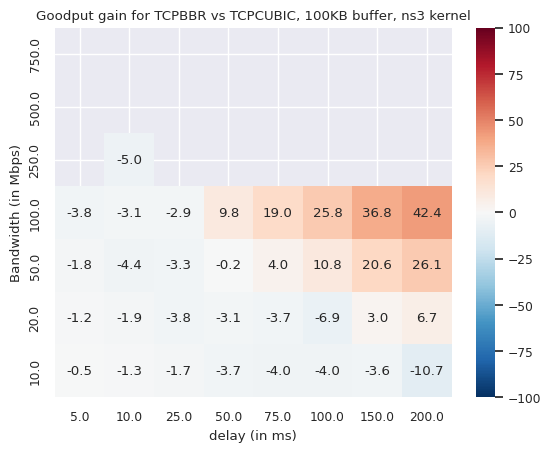

In [141]:
dat_hm = df_tput[df_tput.qdiscSize==100].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="goodput_gain")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".1f", cmap="RdBu_r", center=0, vmin=-100, vmax=100)
ax.invert_yaxis()
ax.set_title("Goodput gain for " + exp_factors['tcpTypeId'][1].upper() + " vs " + exp_factors['tcpTypeId'][0].upper() + ", 100KB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

In [134]:
dat_hm.head()

delay,5.0,10.0,25.0,50.0,75.0,100.0,150.0,200.0
bottleneck_bandwidth,,,,,,,,
10.0,-0.456218,-1.318087,-1.663407,-3.697412,-3.992935,-3.975311,-3.646934,-10.675800
20.0,-1.160289,-1.943998,-3.754109,-3.086825,-3.727745,-6.892402,3.027518,6.694454
50.0,-1.764500,-4.416764,-3.345110,-0.247606,4.042262,10.827370,20.570938,26.105772
100.0,-3.830289,-3.061541,-2.921774,9.823181,18.987780,25.816000,36.756130,42.371253
250.0,NaN,-4.976647,NaN,NaN,NaN,NaN,NaN,NaN


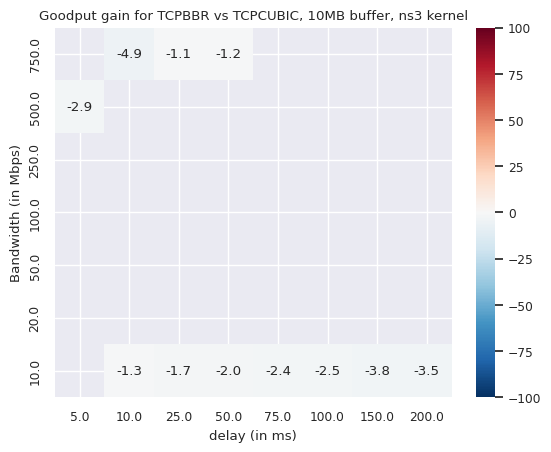

In [142]:
dat_hm = df_tput[df_tput.qdiscSize==10].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="goodput_gain")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".1f", cmap="RdBu_r", center=0, vmin=-100, vmax=100)
ax.invert_yaxis()
ax.set_title("Goodput gain for " + exp_factors['tcpTypeId'][1].upper() + " vs " + exp_factors['tcpTypeId'][0].upper() + ", 10MB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

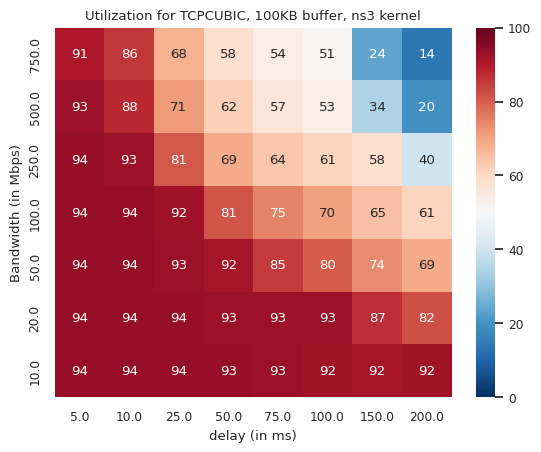

In [136]:
df_tput = pd.read_csv("../../tcp-brr-cubic-results/results.csv", names = ['qdiscSize','bandwidth','delay','trial','tcpTypeId','goodput_', 'ret'])
df_tput = df_tput.drop(columns=['ret'])
df_tput['goodput_'] = pd.to_numeric(df_tput['goodput_'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='tcpTypeId', index=['qdiscSize','bandwidth','delay'], values=['goodput_'], aggfunc='mean').reset_index() 
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(util = 100*(df_tput['goodput_' + exp_factors['tcpTypeId'][0] ]/(df_tput['bandwidth']*1000)))
dat_hm = df_tput[df_tput.qdiscSize==100].pivot(index=["bandwidth"], columns=["delay"], values="util")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=50, vmin=0, vmax=100)
ax.invert_yaxis()
ax.set_title("Utilization for " + exp_factors['tcpTypeId'][0].upper() + ", 100KB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

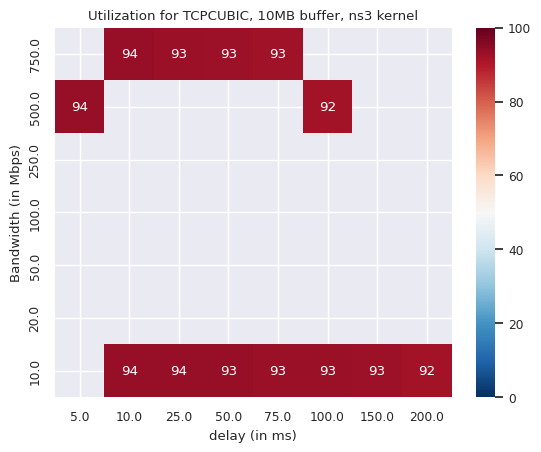

In [143]:
df_tput = pd.read_csv("../../tcp-brr-cubic-results/results.csv", names = ['qdiscSize','bandwidth','delay','trial','tcpTypeId','goodput_', 'ret'])
df_tput = df_tput.drop(columns=['ret'])
df_tput['goodput_'] = pd.to_numeric(df_tput['goodput_'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='tcpTypeId', index=['qdiscSize','bandwidth','delay'], values=['goodput_'], aggfunc='mean').reset_index() 
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(util = 100*(df_tput['goodput_' + exp_factors['tcpTypeId'][0] ]/(df_tput['bandwidth']*1000)))
dat_hm = df_tput[df_tput.qdiscSize==10].pivot(index=["bandwidth"], columns=["delay"], values="util")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=50, vmin=0, vmax=100)
ax.invert_yaxis()
ax.set_title("Utilization for " + exp_factors['tcpTypeId'][0].upper() + ", 10MB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

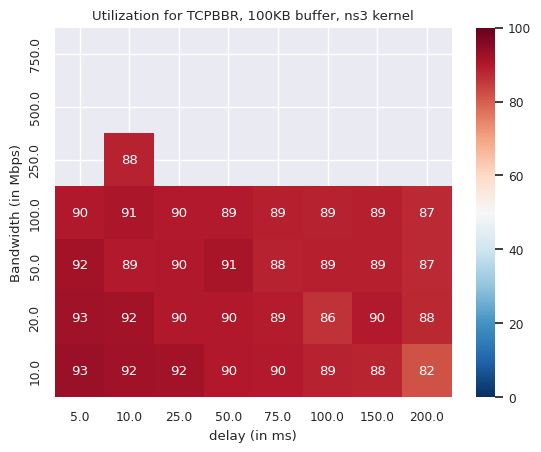

In [128]:
df_tput = pd.read_csv("../../tcp-brr-cubic-results/results.csv", names = ['qdiscSize','bandwidth','delay','trial','tcpTypeId','goodput_', 'ret'])
df_tput = df_tput.drop(columns=['ret'])
df_tput['goodput_'] = pd.to_numeric(df_tput['goodput_'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='tcpTypeId', index=['qdiscSize','bandwidth','delay'], values=['goodput_'], aggfunc='mean').reset_index() 
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(util = 100*(df_tput['goodput_' + exp_factors['tcpTypeId'][1] ]/(df_tput['bandwidth']*1000)))
dat_hm = df_tput[df_tput.qdiscSize==100].pivot(index=["bandwidth"], columns=["delay"], values="util")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=50, vmin=0, vmax=100)
ax.invert_yaxis()
ax.set_title("Utilization for " + exp_factors['tcpTypeId'][1].upper() + ", 100KB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

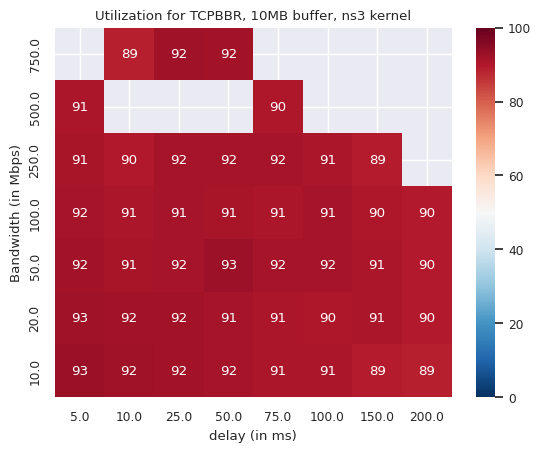

In [129]:
df_tput = pd.read_csv("../../tcp-brr-cubic-results/results.csv", names = ['qdiscSize','bandwidth','delay','trial','tcpTypeId','goodput_', 'ret'])
df_tput = df_tput.drop(columns=['ret'])
df_tput['goodput_'] = pd.to_numeric(df_tput['goodput_'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='tcpTypeId', index=['qdiscSize','bandwidth','delay'], values=['goodput_'], aggfunc='mean').reset_index() 
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(util = 100*(df_tput['goodput_' + exp_factors['tcpTypeId'][1] ]/(df_tput['bandwidth']*1000)))
dat_hm = df_tput[df_tput.qdiscSize==10].pivot(index=["bandwidth"], columns=["delay"], values="util")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=50, vmin=0, vmax=100)
ax.invert_yaxis()
ax.set_title("Utilization for " + exp_factors['tcpTypeId'][1].upper() + ", 10MB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()